In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(r'Senior DA task.csv')
data.describe()

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END
count,170526,170526,170526,170526,34235,170526,170526
unique,966,28,99738,2,206,966,966
top,33f0b98a557961f5ccc519bb972d450f,Scheduling.Shift.Created,2024-03-11 13:25:12.000,False,2024-04-04 15:25:04.000,2024-03-20 11:01:59.000,2024-04-19 11:01:59.000
freq,12136,96895,512,136291,3826,12136,12136


In [3]:
# Check if there are arganisations with ambiguous assigned Converted flag
mixed_conversion_orgs = data.groupby('ORGANIZATION_ID')['CONVERTED'].nunique()
mixed_conversion_orgs = mixed_conversion_orgs[mixed_conversion_orgs > 1]
mixed_conversion_orgs

Series([], Name: CONVERTED, dtype: int64)

In [4]:
# Check if there are duplicates
sum(data.duplicated())

67631

In [5]:
# Check duplicates
data[data.duplicated()]

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END
153,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-04-17 22:58:40.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
155,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-04-17 22:58:41.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
156,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-04-17 22:58:41.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
195,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.AssignmentChanged,2024-04-19 17:52:03.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
196,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.AssignmentChanged,2024-04-19 17:52:03.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
...,...,...,...,...,...,...,...
170509,4eb736e6ff7851d301ae68a6aa37081a,Scheduling.Shift.Created,2024-01-25 09:53:33.000,False,NaN,2024-01-04 12:07:40.000,2024-02-03 12:07:40.000
170510,4eb736e6ff7851d301ae68a6aa37081a,Scheduling.Shift.Created,2024-01-25 09:53:33.000,False,NaN,2024-01-04 12:07:40.000,2024-02-03 12:07:40.000
170511,4eb736e6ff7851d301ae68a6aa37081a,Scheduling.Shift.Created,2024-01-25 09:53:33.000,False,NaN,2024-01-04 12:07:40.000,2024-02-03 12:07:40.000
170512,4eb736e6ff7851d301ae68a6aa37081a,Scheduling.Shift.Created,2024-01-25 09:53:33.000,False,NaN,2024-01-04 12:07:40.000,2024-02-03 12:07:40.000


In [6]:
# Let's drop them
data = data.drop_duplicates()

In [7]:
# Filter out activities which happened after conversion
data = data[(data['TIMESTAMP'] < data['CONVERTED_AT']) | (~data['CONVERTED'])]

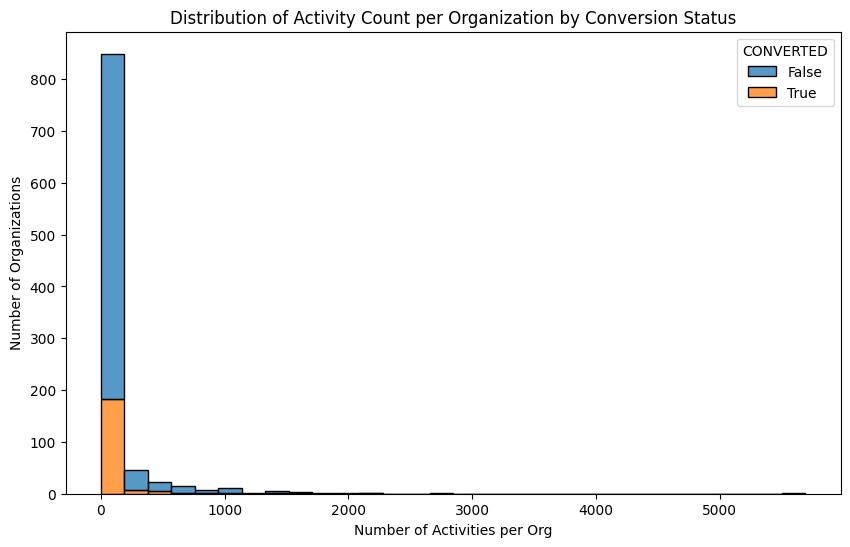

In [8]:
# Distribution of count of activities per org
activity_counts = data.groupby(['CONVERTED', 'ORGANIZATION_ID']).size().reset_index(name='ACTIVITY_COUNT')

plt.figure(figsize=(10, 6))
sns.histplot(data=activity_counts, x='ACTIVITY_COUNT', hue='CONVERTED', bins=30, kde=False, multiple='stack')

plt.title('Distribution of Activity Count per Organization by Conversion Status')
plt.xlabel('Number of Activities per Org')
plt.ylabel('Number of Organizations')
plt.show()

In [9]:
# Based on histagram, data seem to be significantly scewed, let's calculate scewness.

from scipy.stats import skew

print("Skewness:", skew(activity_counts['ACTIVITY_COUNT']))

Skewness: 7.885813836357933


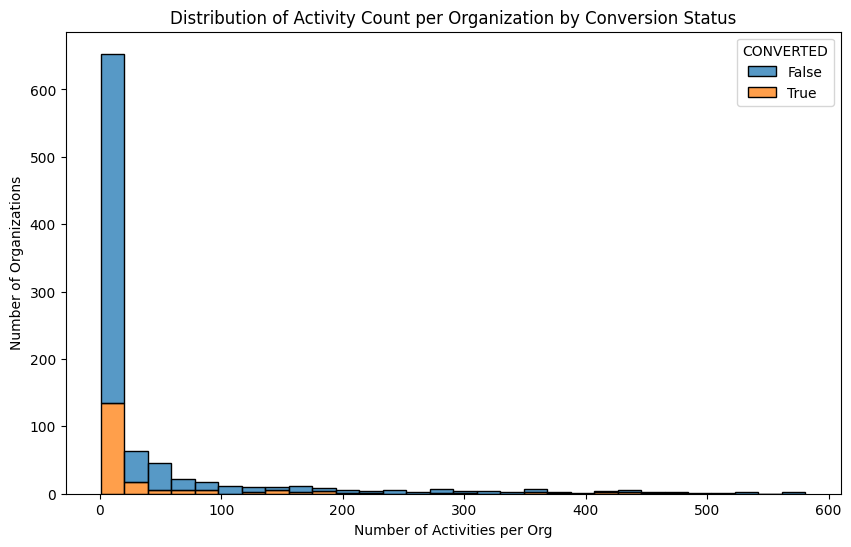

In [10]:
# Filter outliers
data = data.merge(activity_counts, on=['ORGANIZATION_ID', 'CONVERTED'])
upper_bound =  activity_counts['ACTIVITY_COUNT'].quantile(0.95)

# Filter out outliers
filtered_data = data[data['ACTIVITY_COUNT'] <= upper_bound]

# Visualize distribution for filtered data
new_activity_counts = filtered_data.groupby(['CONVERTED', 'ORGANIZATION_ID']).size().reset_index(name='ACTIVITY_COUNT')

plt.figure(figsize=(10, 6))
sns.histplot(data=new_activity_counts, x='ACTIVITY_COUNT', hue='CONVERTED', bins=30, kde=False, multiple='stack')

plt.title('Distribution of Activity Count per Organization by Conversion Status')
plt.xlabel('Number of Activities per Org')
plt.ylabel('Number of Organizations')
plt.show()

In [11]:
# Let's check skewness of new dataset
print("Skewness:", skew(new_activity_counts['ACTIVITY_COUNT']))

Skewness: 3.147022092988748


In [12]:
filtered_data.groupby('CONVERTED')['ORGANIZATION_ID'].nunique()

CONVERTED
False    721
True     197
Name: ORGANIZATION_ID, dtype: int64

In [13]:
# Mean and median number of activities per org in each converted category
new_activity_counts.groupby('CONVERTED').agg({
    'ACTIVITY_COUNT': ['mean', 'median']
})

ACTIVITY_COUNT       
                    mean median
CONVERTED                      
False          45.091540    7.0
True           47.020305    7.0

In [14]:
activity_metrics = filtered_data.groupby(by = ['ACTIVITY_NAME', 'CONVERTED']).agg({
    'ORGANIZATION_ID': ['count', 'nunique']
})
activity_metrics.columns = ['NB_ACTIVITIES', 'NB_ORGANIZATIONS']
activity_metrics = activity_metrics.reset_index()
activity_metrics['AVG_ACTIVITIES_PER_ORG'] = activity_metrics['NB_ACTIVITIES'] / activity_metrics['NB_ORGANIZATIONS']
activity_metrics

,ACTIVITY_NAME,CONVERTED,NB_ACTIVITIES,NB_ORGANIZATIONS,AVG_ACTIVITIES_PER_ORG
0,Absence.Request.Approved,False,33,15,2.200000
1,Absence.Request.Approved,True,45,5,9.000000
2,Absence.Request.Created,False,46,17,2.705882
3,Absence.Request.Created,True,53,6,8.833333
4,Absence.Request.Rejected,False,4,3,1.333333
5,Absence.Request.Rejected,True,3,2,1.500000
6,Break.Activate.Finished,False,2,2,1.000000
7,Break.Activate.Finished,True,30,1,30.000000
8,Break.Activate.Started,False,2,2,1.000000
9,Break.Activate.Started,True,29,1,29.000000


In [15]:
pivoted = activity_metrics.pivot(
    index='ACTIVITY_NAME',
    columns='CONVERTED',
    values=['NB_ACTIVITIES', 'NB_ORGANIZATIONS', 'AVG_ACTIVITIES_PER_ORG']
)
pivoted.columns = [f"{col}_{'CONVERTED' if conv  else 'NOT_CONVERTED'}" for col, conv in pivoted.columns]
pivoted = pivoted.reset_index().fillna(0)
pivoted['IS_AVG_HIGHER_IN_CONVERTED'] = pivoted['AVG_ACTIVITIES_PER_ORG_CONVERTED'] > pivoted['AVG_ACTIVITIES_PER_ORG_NOT_CONVERTED']
pivoted['IS_NUMBER_OF_ORGS_RELEVANT'] = (pivoted['NB_ORGANIZATIONS_NOT_CONVERTED']>=10) & (pivoted['NB_ORGANIZATIONS_CONVERTED']>=10) & (pivoted['NB_ORGANIZATIONS_NOT_CONVERTED'] + pivoted['NB_ORGANIZATIONS_CONVERTED']>=30)
pivoted

,ACTIVITY_NAME,NB_ACTIVITIES_NOT_CONVERTED,NB_ACTIVITIES_CONVERTED,NB_ORGANIZATIONS_NOT_CONVERTED,NB_ORGANIZATIONS_CONVERTED,AVG_ACTIVITIES_PER_ORG_NOT_CONVERTED,AVG_ACTIVITIES_PER_ORG_CONVERTED,IS_AVG_HIGHER_IN_CONVERTED,IS_NUMBER_OF_ORGS_RELEVANT
0,Absence.Request.Approved,33.0,45.0,15.0,5.0,2.200000,9.000000,True,False
1,Absence.Request.Created,46.0,53.0,17.0,6.0,2.705882,8.833333,True,False
2,Absence.Request.Rejected,4.0,3.0,3.0,2.0,1.333333,1.500000,True,False
3,Break.Activate.Finished,2.0,30.0,2.0,1.0,1.000000,30.000000,True,False
4,Break.Activate.Started,2.0,29.0,2.0,1.0,1.000000,29.000000,True,False
5,Communication.Message.Created,479.0,62.0,91.0,17.0,5.263736,3.647059,False,True
6,Integration.Xero.PayrollExport.Synced,23.0,2.0,3.0,1.0,7.666667,2.000000,False,False
7,Mobile.Schedule.Loaded,11043.0,2954.0,320.0,88.0,34.509375,33.568182,False,True
8,PunchClock.Entry.Edited,2.0,0.0,2.0,0.0,1.000000,0.000000,False,False
9,PunchClock.PunchedIn,1354.0,302.0,126.0,39.0,10.746032,7.743590,False,True


In [16]:
pivoted[(pivoted['IS_NUMBER_OF_ORGS_RELEVANT'])]

activities_for_model = pivoted['ACTIVITY_NAME'][(pivoted['IS_NUMBER_OF_ORGS_RELEVANT'])].to_list()

### Prepare dataset

In [26]:
# Calculating day difference between activity and trial start date
filtered_data['TIMESTAMP'] = pd.to_datetime(filtered_data['TIMESTAMP'])
filtered_data['TRIAL_START'] = pd.to_datetime(filtered_data['TRIAL_START'])
filtered_data['DAYS_SINCE_TRIAL_STARTED'] = (filtered_data['TIMESTAMP'] - filtered_data['TRIAL_START']).dt.days
filtered_data['ACTIVITY_DATE'] = filtered_data['TIMESTAMP'].dt.date

# Counting activities which happened within 3, 7 and 14 days
def count_activities_within_days(data, nb_days):
    return data[data['DAYS_SINCE_TRIAL_STARTED']<=nb_days].groupby(by='ORGANIZATION_ID').size()

def count_selected_activities_within_days(data, nb_days):
    return data[(data['DAYS_SINCE_TRIAL_STARTED']<=nb_days) & (data['ACTIVITY_NAME'].isin(activities_for_model))].groupby(by='ORGANIZATION_ID').size()

activity_features_3d = count_activities_within_days(filtered_data, 3).rename('nb_activities_3d')
activity_features_7d = count_activities_within_days(filtered_data, 7).rename('nb_activities_7d')
activity_features_14d = count_activities_within_days(filtered_data, 14).rename('nb_activities_14d')

selected_activity_features_3d = count_selected_activities_within_days(filtered_data, 3).rename('nb_selected_activities_3d')
selected_activity_features_7d = count_selected_activities_within_days(filtered_data, 7).rename('nb_selected_activities_7d')
selected_activity_features_14d = count_selected_activities_within_days(filtered_data, 14).rename('nb_selected_activities_14d')

activity_features_days = pd.concat([activity_features_14d, activity_features_7d, activity_features_3d, selected_activity_features_14d, selected_activity_features_7d, selected_activity_features_3d], axis = 1).fillna(0)
activity_features_days

C:\Users\komputer\AppData\Local\Temp\ipykernel_24372\1523318451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['TIMESTAMP'] = pd.to_datetime(filtered_data['TIMESTAMP'])
C:\Users\komputer\AppData\Local\Temp\ipykernel_24372\1523318451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['TRIAL_START'] = pd.to_datetime(filtered_data['TRIAL_START'])
C:\Users\komputer\AppData\Local\Temp\ipykernel_24372\1523318451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy

,nb_activities_14d,nb_activities_7d,nb_activities_3d,nb_selected_activities_14d,nb_selected_activities_7d,nb_selected_activities_3d
ORGANIZATION_ID,,,,,,
00456fd86311b6095ad05f7e31758f0d,6,6.0,6.0,6.0,6.0,6.0
007d48a2bc006e6eac0348c788d26dfd,5,5.0,5.0,5.0,5.0,5.0
00d6461845d0042b929379c263e9edef,2,0.0,0.0,2.0,0.0,0.0
00f00e783ff21fd62404d10ced5cd45f,6,6.0,6.0,6.0,6.0,6.0
014d8cdf08111d7442887a4704b47caa,14,14.0,14.0,14.0,14.0,14.0
...,...,...,...,...,...,...
4e44f506184abb41230dca9183e0dfde,92,72.0,60.0,92.0,72.0,60.0
4e76bb8e72c66ac1020407778635938f,137,137.0,137.0,137.0,137.0,137.0
4e7e4c7bd153b3e8728e7be9e717071b,7,7.0,7.0,7.0,7.0,7.0


In [37]:
def count_active_days_within_specified_timeframe(data, nb_days):
    active_days = data[['ORGANIZATION_ID', 'DAYS_SINCE_TRIAL_STARTED']].drop_duplicates()
    return active_days[active_days['DAYS_SINCE_TRIAL_STARTED']<nb_days].groupby(by='ORGANIZATION_ID').size()

activity_features_3d = count_active_days_within_specified_timeframe(filtered_data, 3).rename('nb_active_days_3d')
activity_features_7d = count_active_days_within_specified_timeframe(filtered_data, 7).rename('nb_active_days_7d')
activity_features_14d = count_active_days_within_specified_timeframe(filtered_data, 14).rename('nb_active_days_14d')
activity_features_30d = count_active_days_within_specified_timeframe(filtered_data, 30).rename('nb_active_days_30d')

time_features = pd.concat([activity_features_days, activity_features_3d, activity_features_7d, activity_features_14d, activity_features_30d], axis = 1).fillna(0)

In [39]:
activity_features_relevant_activities = filtered_data[filtered_data['ACTIVITY_NAME'].isin(activities_for_model)]
activity_features = activity_features_relevant_activities.pivot_table(
    index=['ORGANIZATION_ID', 'CONVERTED'],
    columns='ACTIVITY_NAME',
    aggfunc='size',
    fill_value=0
).reset_index()
final_data = activity_features.merge(time_features, how = 'left', on = 'ORGANIZATION_ID').fillna(0)
final_data

,ORGANIZATION_ID,CONVERTED,Communication.Message.Created,Mobile.Schedule.Loaded,PunchClock.PunchedIn,Scheduling.Shift.Approved,Scheduling.Shift.AssignmentChanged,Scheduling.Shift.Created,Scheduling.Template.ApplyModal.Applied,nb_activities_14d,nb_activities_7d,nb_activities_3d,nb_selected_activities_14d,nb_selected_activities_7d,nb_selected_activities_3d,nb_active_days_3d,nb_active_days_7d,nb_active_days_14d,nb_active_days_30d
0,00456fd86311b6095ad05f7e31758f0d,False,1,1,0,0,3,1,0,6.0,6.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0,1
1,007d48a2bc006e6eac0348c788d26dfd,False,0,4,1,0,0,0,0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,2
2,00d6461845d0042b929379c263e9edef,False,0,0,1,0,0,1,0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1
3,00f00e783ff21fd62404d10ced5cd45f,False,0,0,0,0,2,4,0,6.0,6.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0,1
4,014d8cdf08111d7442887a4704b47caa,False,0,0,0,0,5,9,0,14.0,14.0,14.0,14.0,14.0,14.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,4e44f506184abb41230dca9183e0dfde,True,0,64,4,1,0,23,0,92.0,72.0,60.0,92.0,72.0,60.0,3.0,5.0,7.0,7
911,4e76bb8e72c66ac1020407778635938f,False,0,0,0,41,3,93,0,137.0,137.0,137.0,137.0,137.0,137.0,1.0,1.0,1.0,1
912,4e7e4c7bd153b3e8728e7be9e717071b,False,0,0,0,0,0,7,0,7.0,7.0,7.0,7.0,7.0,7.0,1.0,1.0,1.0,1
913,4e900f739ad1a3cc11c0bc2ad85db6ff,False,0,0,0,0,0,84,0,84.0,84.0,84.0,84.0,84.0,84.0,1.0,1.0,1.0,1


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

X = final_data.iloc[:, 2:]
y = final_data.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X_train.columns

classifier = RandomForestClassifier(n_estimators=20, max_depth=12, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

Accuracy: 79.23%


array([[144,   5],
       [ 33,   1]])

In [41]:
importances = classifier.feature_importances_
pd.Series(importances, index=feature_names).sort_values(ascending=False)


Scheduling.Shift.Created                  0.116392
nb_activities_14d                         0.094588
nb_selected_activities_14d                0.088738
Mobile.Schedule.Loaded                    0.088305
nb_selected_activities_7d                 0.080591
nb_activities_3d                          0.070056
nb_selected_activities_3d                 0.063755
nb_activities_7d                          0.061107
Scheduling.Shift.AssignmentChanged        0.057074
PunchClock.PunchedIn                      0.050531
Scheduling.Shift.Approved                 0.049967
nb_active_days_14d                        0.040928
nb_active_days_30d                        0.037028
Scheduling.Template.ApplyModal.Applied    0.034550
nb_active_days_7d                         0.026524
Communication.Message.Created             0.022148
nb_active_days_3d                         0.017717
dtype: float64

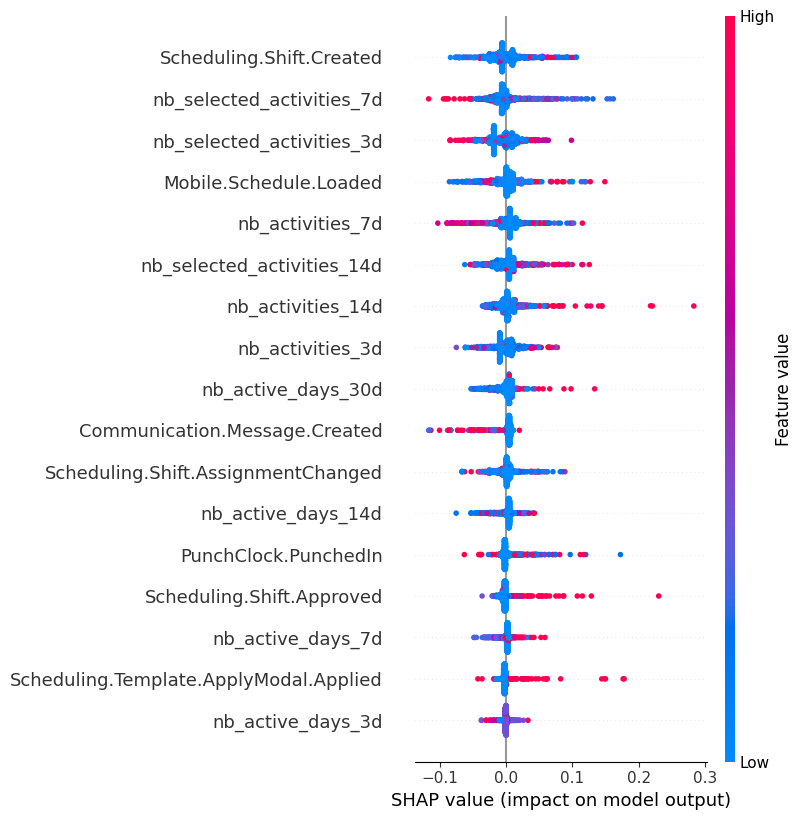

In [51]:
import shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[:, :, 1], X_train)

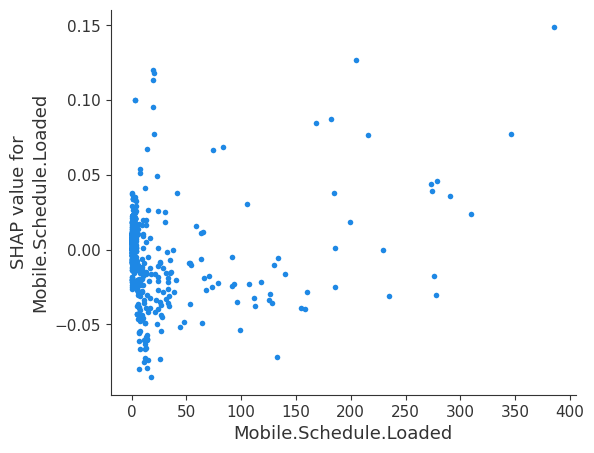

In [52]:
shap.dependence_plot('Mobile.Schedule.Loaded', shap_values[:,:,1], X_train, interaction_index=None)

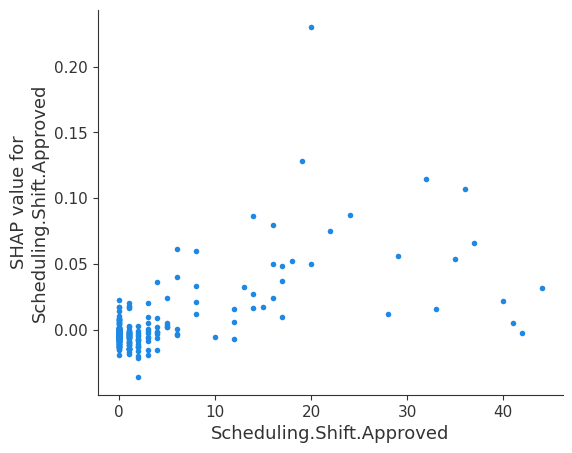

In [53]:
shap.dependence_plot('Scheduling.Shift.Approved', shap_values[:,:,1], X_train, interaction_index=None)

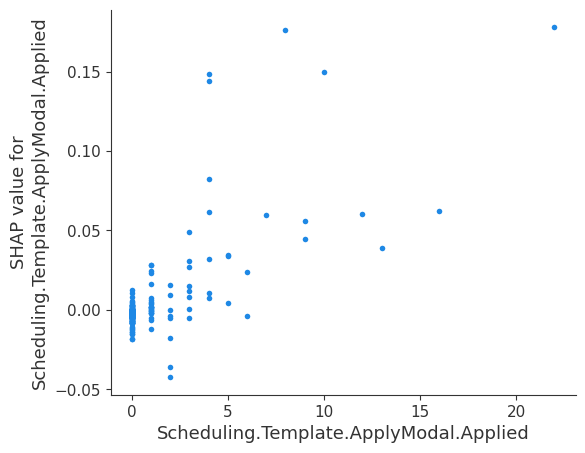

In [54]:
shap.dependence_plot('Scheduling.Template.ApplyModal.Applied', shap_values[:,:,1], X_train, interaction_index=None)

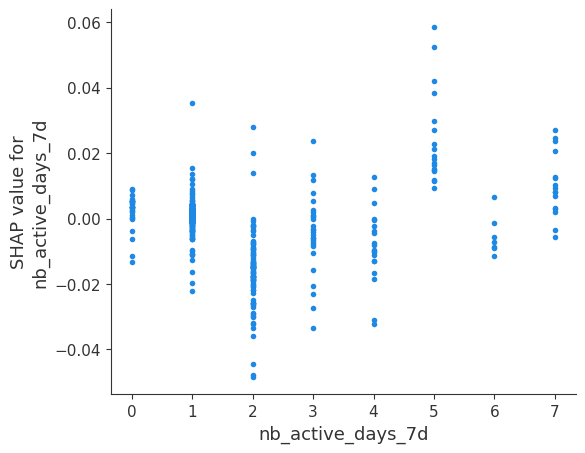

In [58]:
shap.dependence_plot('nb_active_days_7d', shap_values[:,:,1], X_train, interaction_index=None)

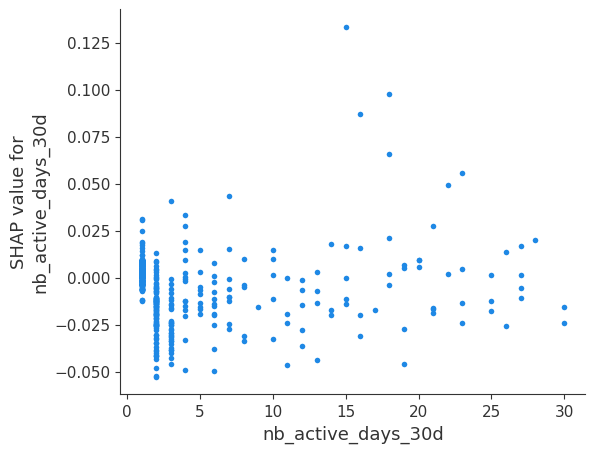

In [61]:
shap.dependence_plot('nb_active_days_30d', shap_values[:,:,1], X_train, interaction_index=None)

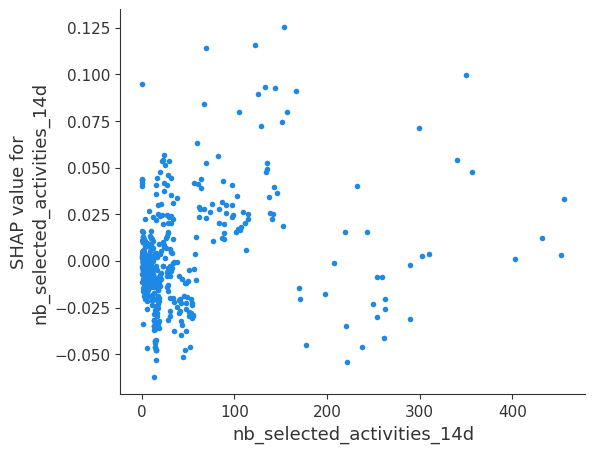

In [62]:
shap.dependence_plot('nb_selected_activities_14d', shap_values[:,:,1], X_train, interaction_index=None)